In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pickle


In [2]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

objpoints = []
imgpoints = []
obj_point = []

obj_point = np.zeros((6*9,3),np.float32)
obj_point[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

nx = 9
ny = 6

images = glob.glob('./camera_cal/calibration*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    if ret == True:
        print ('working on ', fname)
        objpoints.append(obj_point)
        imgpoints.append(corners)
        
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    

working on  ./camera_cal/calibration12.jpg
working on  ./camera_cal/calibration9.jpg
working on  ./camera_cal/calibration17.jpg
working on  ./camera_cal/calibration13.jpg
working on  ./camera_cal/calibration15.jpg
working on  ./camera_cal/calibration20.jpg
working on  ./camera_cal/calibration10.jpg
working on  ./camera_cal/calibration16.jpg
working on  ./camera_cal/calibration2.jpg
working on  ./camera_cal/calibration3.jpg
working on  ./camera_cal/calibration7.jpg
working on  ./camera_cal/calibration18.jpg
working on  ./camera_cal/calibration14.jpg
working on  ./camera_cal/calibration19.jpg
working on  ./camera_cal/calibration6.jpg
working on  ./camera_cal/calibration8.jpg
working on  ./camera_cal/calibration11.jpg


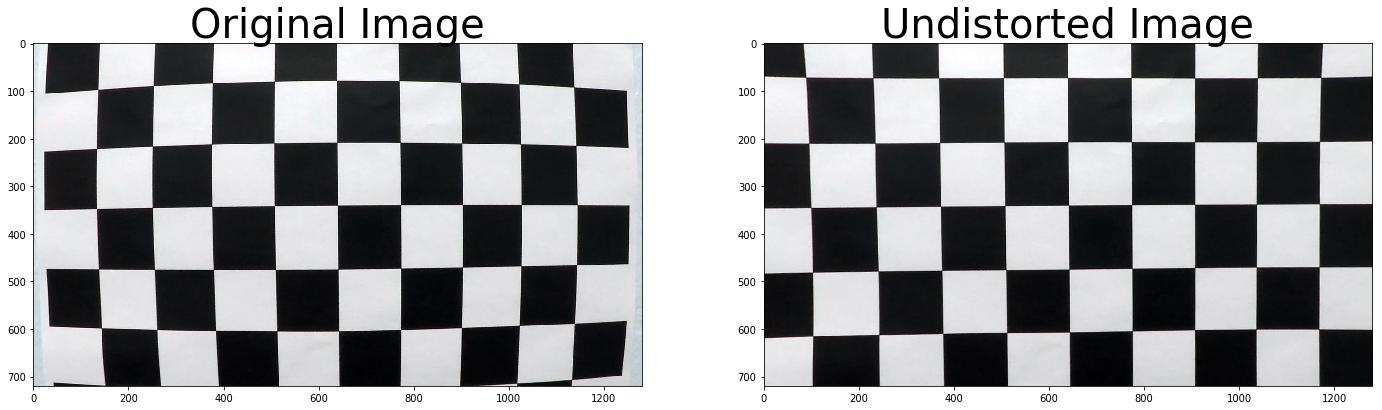

In [3]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx) 

cal_image = cv2.imread('./camera_cal/calibration1.jpg')
undist = undistort(cal_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))

ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)


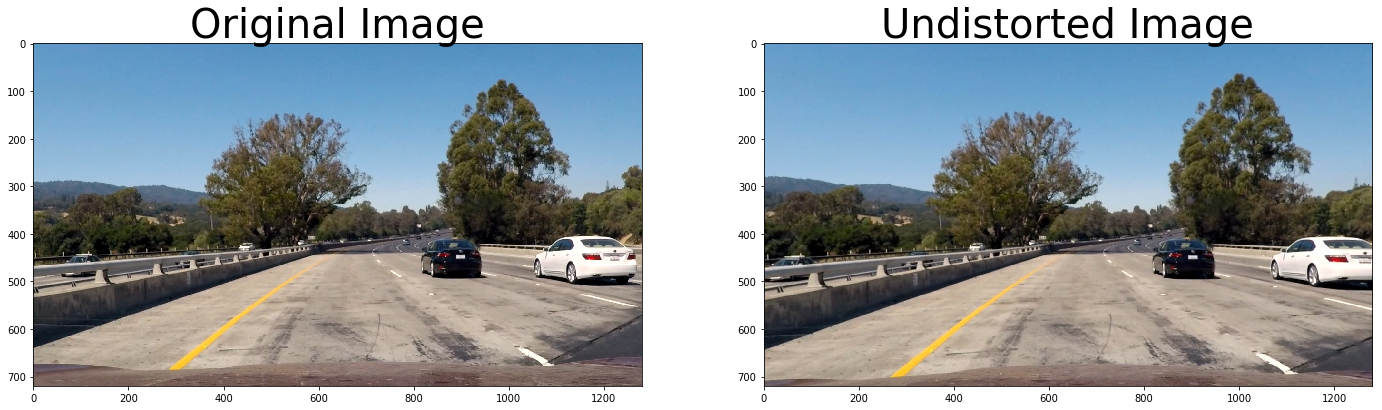

In [4]:
# An example image (test1) that is transformed to undistorted state

ex_image = mpimg.imread('./test_images/test1.jpg')
undist = undistort(ex_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.imshow(ex_image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)


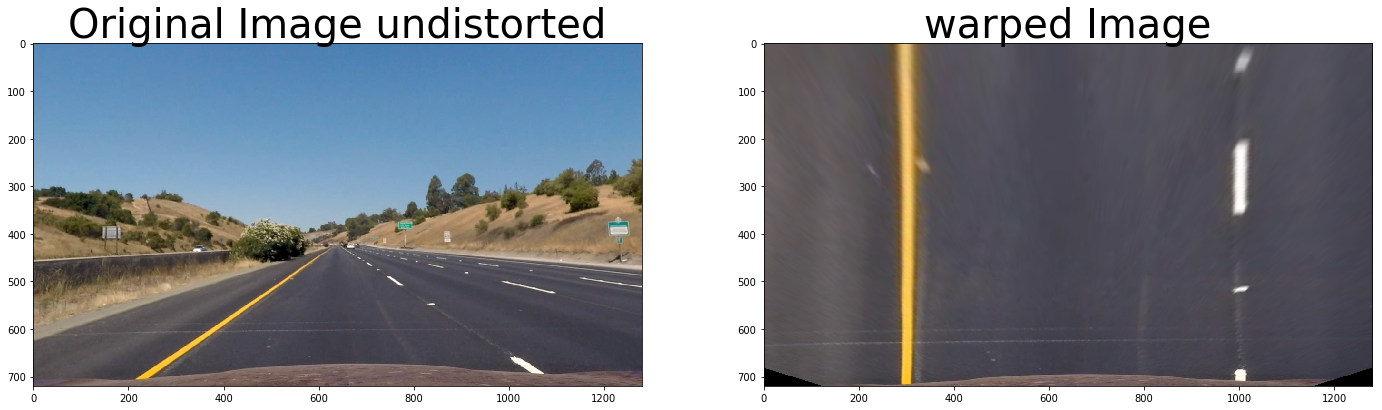

In [5]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
undist = undistort(img, mtx, dist)

bottom_left = (265,680)
bottom_right = (1040,680)
top_left = [525,500]
top_right = [762, 500]

img_size = (img.shape[1], img.shape[0])

top_left_dst = [300,300]
top_right_dst = [1000,300]
bottom_right_dst = [1000,700]
bottom_left_dst = [300,700]


src = np.float32([[top_left, top_right, bottom_right, bottom_left]])
dst = np.float32([[top_left_dst, top_right_dst, bottom_right_dst, bottom_left_dst]])


# Given src and dst points, the perspective transform matrix is calculated
M = cv2.getPerspectiveTransform(src, dst)

# inverse perspective transform is also calculated here, which would be used later in the code
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image using OpenCV warpPerspective()

def perspective(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

warped = perspective(undist, M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.imshow(undist)
ax1.set_title('Original Image undistorted', fontsize=40)
ax2.imshow(warped)
ax2.set_title('warped Image', fontsize=40)



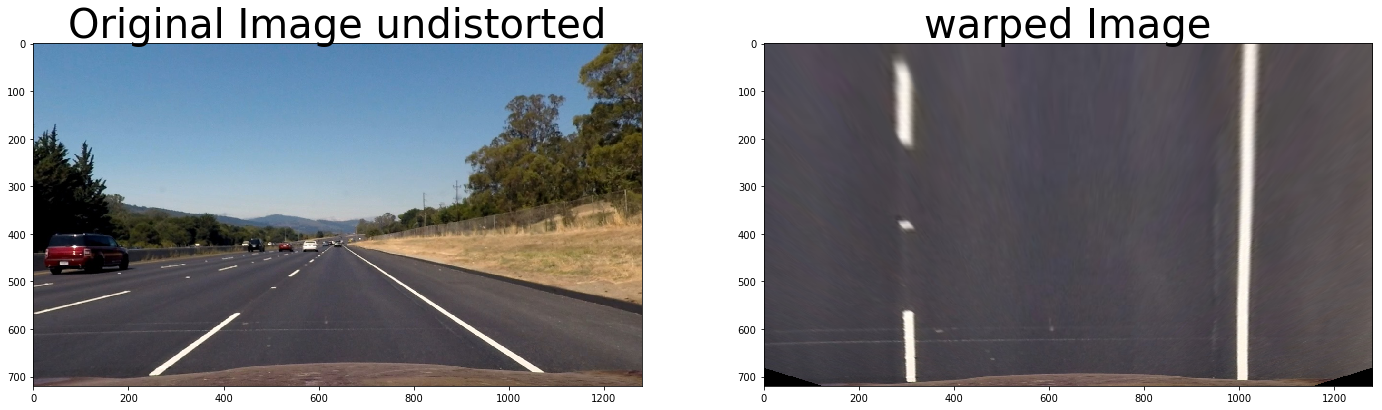

In [6]:
img = mpimg.imread('./test_images/straight_lines2.jpg')
undist = undistort(img, mtx, dist)
warp = perspective(undist, M)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
#f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist)
ax1.set_title('Original Image undistorted', fontsize=40)
ax2.imshow(warp)
ax2.set_title('warped Image', fontsize=40)




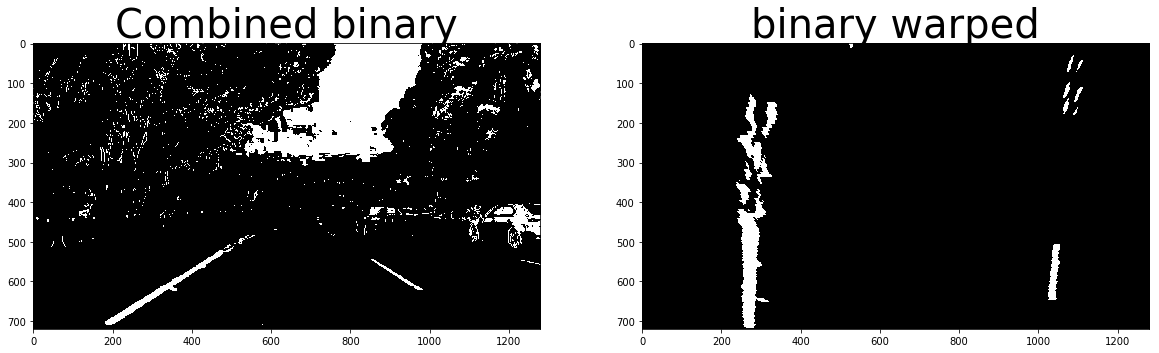

In [7]:
# Binary images

def pipeline (img):
    # Note: img is the undistorted image
    # Explore gradients in other colors spaces / color channels to see what might work better
    
    # Convert to HLS color space and separate the S and l channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    # Sobel x from l-channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient (Sx binary)
    thresh_min = 70
    thresh_max = 200
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    # Threshold color channel (S-channel)
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    
    # Threshold color channel (V-channel)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_thresh_min = 50
    v_thresh_max = 255
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh_min) & (v_channel <= v_thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (v_binary == 1)) | (sxbinary == 1)] = 1
    
    return combined_binary


img = mpimg.imread('./test_images/test5.jpg')
undist = undistort(img, mtx, dist)
combined_binary =  pipeline(undist)
binary_warped = perspective(combined_binary, M)


# Plotting binary images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Combined binary', fontsize=40)
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('binary warped', fontsize=40)
ax2.imshow(binary_warped, cmap='gray')

In [8]:
# thresholds are finalized by running on all test images
images = glob.glob('./test_images/test*.jpg')
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    undist = undistort(img, mtx, dist)
    combined_binary =  pipeline(undist)
    write_name = './test_images/tracked'+str(idx)+'.png'
    mpimg.imsave(write_name,combined_binary)

In [9]:
# Assuming you have created a warped binary image 
# Take a histogram of the bottom half of the image

def Lane_coords(img):
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    leftx = []
    lefty = []
    rightx = []
    righty = []

    # Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

    # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    left_fit, right_fit = (None, None)


# Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    return left_lane_inds, right_lane_inds, left_fit, right_fit, leftx, lefty, rightx, righty



(720, 0)

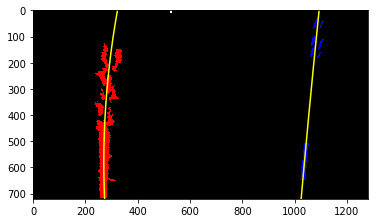

In [10]:

# Generate x and y values for plotting
img = mpimg.imread('./test_images/test5.jpg')
undist = undistort(img, mtx, dist)
combined_binary =  pipeline(undist)
binary_warped = perspective(combined_binary, M)
left_lane_inds, right_lane_inds, left_fit, right_fit, leftx, lefty, rightx, righty = Lane_coords(binary_warped)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

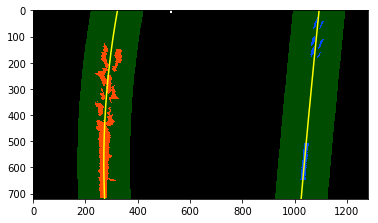

In [11]:
#%matplotlib qt

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
# Set the width of the windows +/- margin
margin = 100

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [12]:
#Method to determine radius of curvature and distance from lane center 
def curv_rad_and_center_dist(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/145 # meters per pixel in y dimension, lane line is 10 ft (3.048 m)
    xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft (3.7 m)
    
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # y-value (bottom of the image) where we want radius of curvature
    
    h = binary_warped.shape[0]
    y_eval = h
    
        
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = binary_warped.shape[1]/2
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [13]:
img = mpimg.imread('./test_images/test5.jpg')
undist = undistort(img, mtx, dist)
combined_binary =  pipeline(undist)
binary_warped = perspective(combined_binary, M)
left_lane_inds, right_lane_inds, left_fit, right_fit, leftx, lefty, rightx, righty = Lane_coords(binary_warped)
rad_l, rad_r, d_center = curv_rad_and_center_dist(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 271.139601565 m, 4100.03217099 m
Distance from lane center for example: -0.0483052391202 m


In [14]:
def draw_lane(original_img, binary_warped, left_fit, right_fit, Minv):
    if left_fit is None or right_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_warped.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.5, 0)
    return result


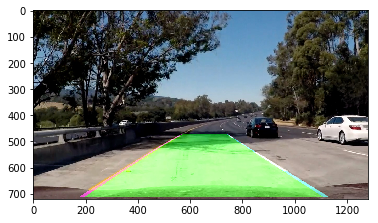

In [15]:
Img_out1 = draw_lane(img, binary_warped, left_fit, right_fit, Minv)
plt.imshow(Img_out1)

In [16]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

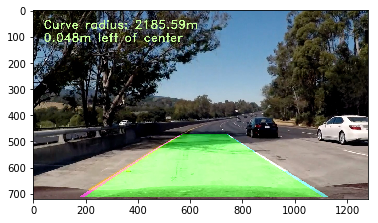

In [17]:
Img_out2 = draw_data(Img_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(Img_out2)


In [18]:
from collections import deque
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=30)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        self.recent_fits = deque(maxlen=30)
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


In [19]:
### Video pipeline
def process_video(image):
    
    img_size = [image.shape[1], image.shape[0]]
    
    undist = undistort(image, mtx, dist)
    combined_binary =  pipeline(undist)
    binary_warped = perspective(combined_binary, M)
    if (left_line.current_fit == None):
        left_lane_inds, right_lane_inds, left_fit, right_fit, leftx, lefty, rightx, righty = Lane_coords(binary_warped)
        left_line.allx = leftx
        left_line.ally = lefty
        right_line.allx = rightx
        right_line.ally = righty
    else:
        left_fit = np.mean(np.asarray(left_line.recent_fits), axis=0)
        right_fit = np.mean(np.asarray(right_line.recent_fits), axis=0)

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        # Again, extract left and right line pixel position
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
        
        if len(leftx) != 0:
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx) != 0:
            right_fit = np.polyfit(righty, rightx, 2)
    
      
    
    left_line.recent_fits.append(left_fit)
    right_line.recent_fits.append(right_fit)
    
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  
        
    left_line.recent_xfitted.append(left_fitx)
    right_line.recent_xfitted.append(right_fitx)
    
    left_line.bestx = np.mean(np.asarray(left_line.recent_xfitted), axis=0)
    right_line.bestx = np.mean(np.asarray(right_line.recent_xfitted), axis=0)
    
    
    rad_l, rad_r, d_center = curv_rad_and_center_dist(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty)
    
    left_line.radius_of_curvature = rad_l
    right_line.radius_of_curvature = rad_r
    
    out_img = draw_lane(image, binary_warped, left_fit, right_fit, Minv)
    final_img = draw_data(out_img, (rad_l+rad_r)/2, d_center)
    return final_img

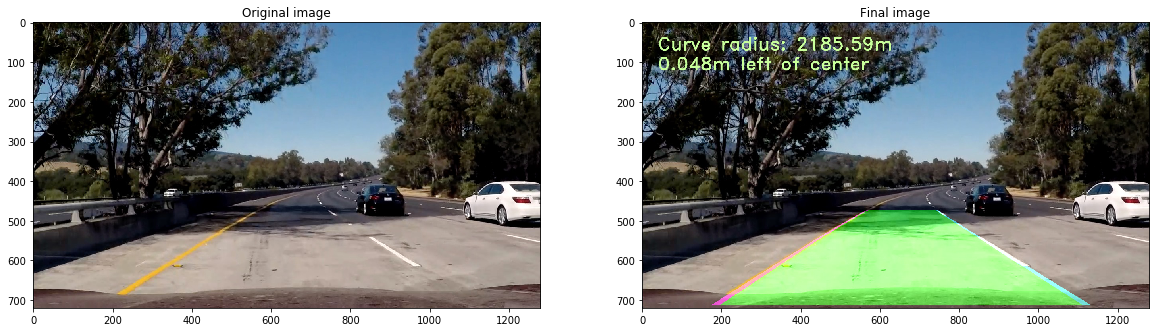

In [20]:
image = mpimg.imread('./test_images/test5.jpg')
left_line = Line()
right_line = Line()
Final_image = process_video(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original image')
ax1.imshow(image)

ax2.set_title('Final image')
ax2.imshow(Final_image)


In [21]:
### Process video
from moviepy.editor import VideoFileClip
left_line = Line()
right_line = Line()
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_video)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:49<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 25s, sys: 8.66 s, total: 7min 33s
Wall time: 4min 51s


In [22]:
from moviepy.editor import VideoFileClip
left_line = Line()
right_line = Line()
output = 'challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
white_clip = clip2.fl_image(process_video)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:38<00:00,  4.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 42s, sys: 3.8 s, total: 2min 46s
Wall time: 1min 40s


In [23]:
from moviepy.editor import VideoFileClip
left_line = Line()
right_line = Line()
output = 'harder_challenge_video_output.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip3.fl_image(process_video)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [04:53<00:00,  4.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 7min 25s, sys: 7.64 s, total: 7min 33s
Wall time: 4min 56s
